Precisión del modelo de Regresión Logística: 0.98
Precisión del modelo Random Forest: 1.00
Precisión del modelo SVM: 0.98


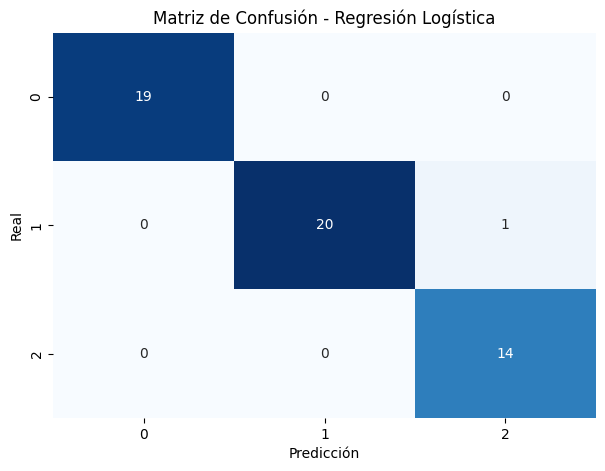

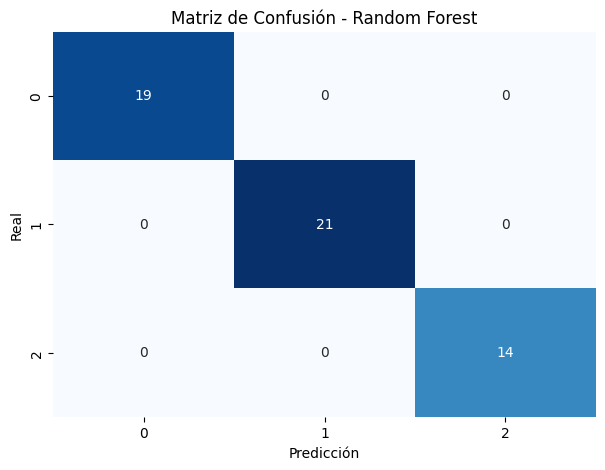

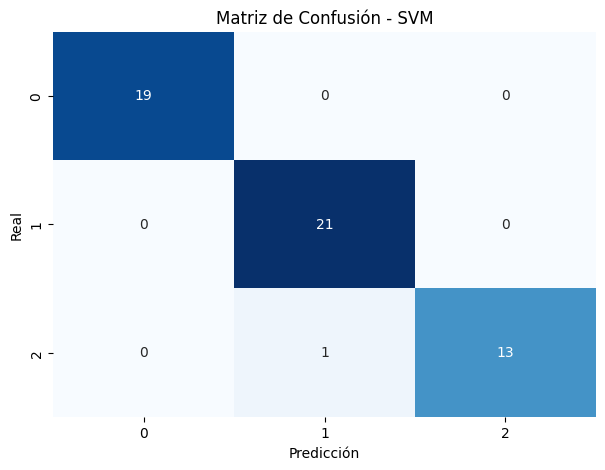

In [1]:
# Importar las bibliotecas necesarias
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar el dataset de vinos
data = load_wine()
X = data.data
y = data.target

# Dividir el dataset en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Estandarizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Modelo de Regresión Logística
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train_scaled, y_train)
y_pred_logreg = logreg.predict(X_test_scaled)
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Precisión del modelo de Regresión Logística: {accuracy_logreg:.2f}")

# 2. Modelo Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Precisión del modelo Random Forest: {accuracy_rf:.2f}")

# 3. Modelo Support Vector Machine (SVM)
svm = SVC()
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Precisión del modelo SVM: {accuracy_svm:.2f}")

# Matrices de confusión
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_svm = confusion_matrix(y_test, y_pred_svm)

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

# Graficar las matrices de confusión
plot_confusion_matrix(cm_logreg, 'Regresión Logística')
plot_confusion_matrix(cm_rf, 'Random Forest')
plot_confusion_matrix(cm_svm, 'SVM')


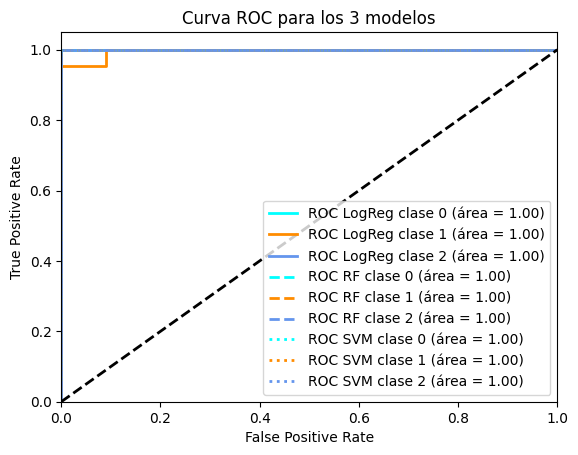

In [2]:
# Importar bibliotecas adicionales necesarias para las gráficas ROC/AUC
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

# Binarizar las etiquetas para calcular AUC/ROC en problemas multiclase
y_train_bin = label_binarize(y_train, classes=[0, 1, 2])
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_train_bin.shape[1]

# Modelos para AUC/ROC
logreg = OneVsRestClassifier(LogisticRegression(max_iter=10000))
rf = OneVsRestClassifier(RandomForestClassifier(random_state=42))
svm = OneVsRestClassifier(SVC(probability=True))

# Entrenar los modelos
logreg.fit(X_train_scaled, y_train_bin)
rf.fit(X_train, y_train_bin)
svm.fit(X_train_scaled, y_train_bin)

# Obtener las probabilidades para el conjunto de prueba
y_score_logreg = logreg.predict_proba(X_test_scaled)
y_score_rf = rf.predict_proba(X_test)
y_score_svm = svm.predict_proba(X_test_scaled)

# Inicializar variables para las curvas ROC
fpr = dict()
tpr = dict()
roc_auc = dict()

# Función para calcular ROC para cada clase y modelo
def calculate_roc_auc(y_test_bin, y_score, model_name):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    return fpr, tpr, roc_auc

# Calcular ROC/AUC para cada modelo
fpr_logreg, tpr_logreg, roc_auc_logreg = calculate_roc_auc(y_test_bin, y_score_logreg, "Logistic Regression")
fpr_rf, tpr_rf, roc_auc_rf = calculate_roc_auc(y_test_bin, y_score_rf, "Random Forest")
fpr_svm, tpr_svm, roc_auc_svm = calculate_roc_auc(y_test_bin, y_score_svm, "SVM")

# Colores para las curvas
colors = cycle(["aqua", "darkorange", "cornflowerblue"])

# Graficar las curvas ROC
plt.figure()

# Graficar para Logistic Regression
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_logreg[i], tpr_logreg[i], color=color, lw=2,
             label=f'ROC LogReg clase {i} (área = {roc_auc_logreg[i]:0.2f})')

# Graficar para Random Forest
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_rf[i], tpr_rf[i], color=color, lw=2, linestyle='--',
             label=f'ROC RF clase {i} (área = {roc_auc_rf[i]:0.2f})')

# Graficar para SVM
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_svm[i], tpr_svm[i], color=color, lw=2, linestyle=':',
             label=f'ROC SVM clase {i} (área = {roc_auc_svm[i]:0.2f})')

# Configuración de la gráfica
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC para los 3 modelos')
plt.legend(loc="lower right")
plt.show()